## Trying out a linear model: 

Author: Alexandru Papiu ([@apapiu](https://twitter.com/apapiu), [GitHub](https://github.com/apapiu))
 
If you use parts of this notebook in your own scripts, please give some sort of credit (for example link back to this). Thanks!


There have been a few [great](https://www.kaggle.com/comartel/house-prices-advanced-regression-techniques/house-price-xgboost-starter/run/348739)  [scripts](https://www.kaggle.com/zoupet/house-prices-advanced-regression-techniques/xgboost-10-kfolds-with-scikit-learn/run/357561) on [xgboost](https://www.kaggle.com/tadepalli/house-prices-advanced-regression-techniques/xgboost-with-n-trees-autostop-0-12638/run/353049) already so I'd figured I'd try something simpler: a regularized linear regression model. Surprisingly it does really well with very little feature engineering. The key point is to to log_transform the numeric variables since most of them are skewed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

### Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BD786E75F8>,
      dtype=object)

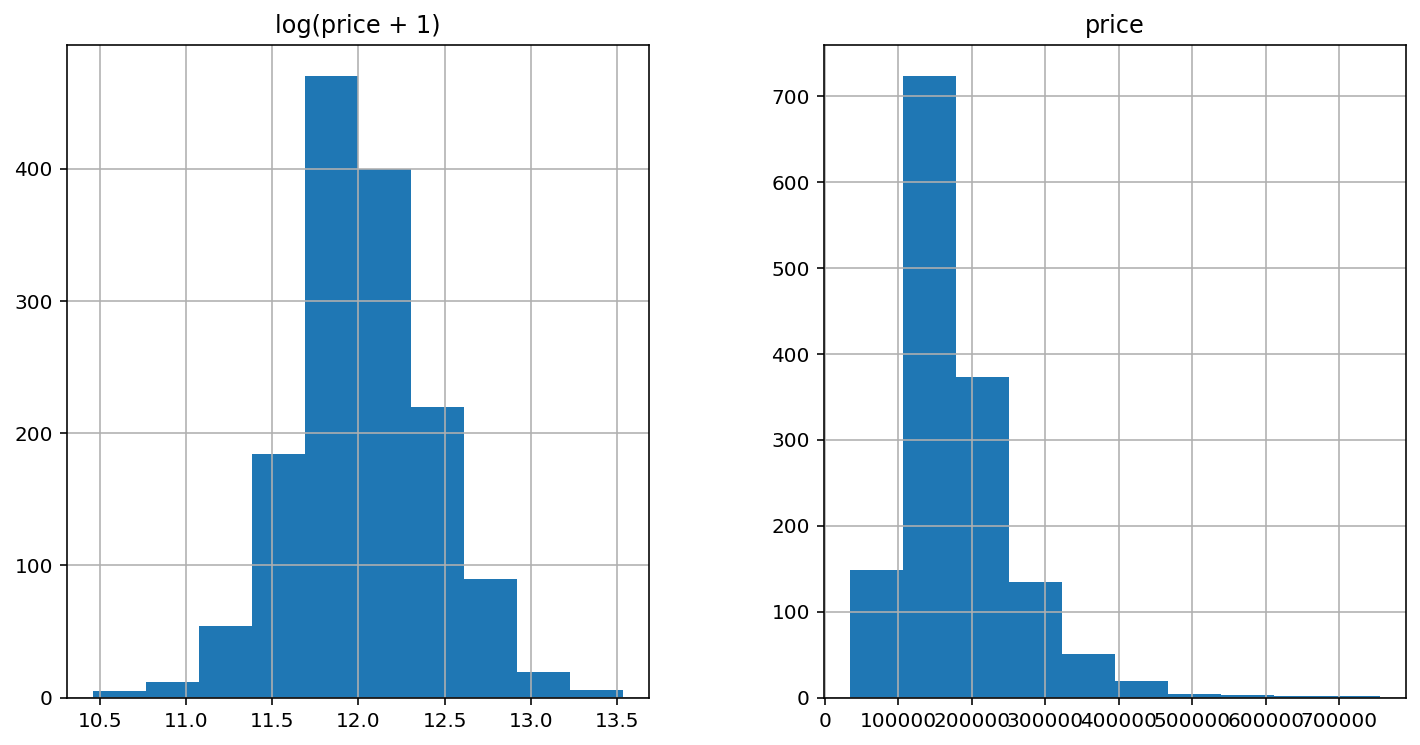

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [6]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log1p
  # This is added back by InteractiveShellApp.init_path()


In [7]:
all_data = pd.get_dummies(all_data)

In [8]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [66]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [73]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [74]:
model_ridge = Ridge(alpha = 0.1)

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [75]:
from sklearn.metrics import mean_squared_error
model_ridge.fit(X_train,y)
pred = model_ridge.predict(X_train) # using X_train since X_test has no SalesPrice to compare to
rmse = np.sqrt(mean_squared_error(y,pred))

In [76]:
print("Ridge Pred: " + str(pred))
print("Ridge RMSE: " + str(rmse))

Ridge Pred: [12.2418857  12.18340581 12.28628096 ... 12.54982583 11.8645212
 11.85610025]
Ridge RMSE: 0.0921195558564051


In [77]:
model_lasso = Lasso(alpha = 0.1)
model_lasso.fit(X_train, y)
pred = model_lasso.predict(X_train) # using X_train since X_test has no SalesPrice to compare to
rmse = np.sqrt(mean_squared_error(y,pred))

In [78]:
print("Lasso Pred: " + str(pred))
print("Lasso RMSE: " + str(rmse))

Lasso Pred: [12.32599498 11.99049435 12.28477897 ... 12.06396816 11.78011099
 11.75582923]
Lasso RMSE: 0.20753905105566584


In [99]:
model_ridge = RidgeCV(alphas = [0.0005, 0.001, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y)
best_alpha = model_ridge.alpha_
model_ridge = Ridge(alpha=best_alpha)
model_ridge.fit(X_train,y)
print("Best alpha for Ridge:  " + str(best_alpha))
print("Score from best alpha: " + str(model_ridge.score(X_train, y)))

Best alpha for Ridge:  10.0
Score from best alpha: 0.9299587783131811


In [100]:
model_lasso = LassoCV(alphas = [0.0005, 0.001, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]).fit(X_train, y)
best_alpha = model_lasso.alpha_
model_lasso = Lasso(alpha=best_alpha)
model_lasso.fit(X_train,y)
print("Best alpha for Ridge:  " + str(best_alpha))
print("Score from best alpha: " + str(model_lasso.score(X_train, y)))

C:\Users\brand\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha for Ridge:  0.0005
Score from best alpha: 0.9308222956470585


Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

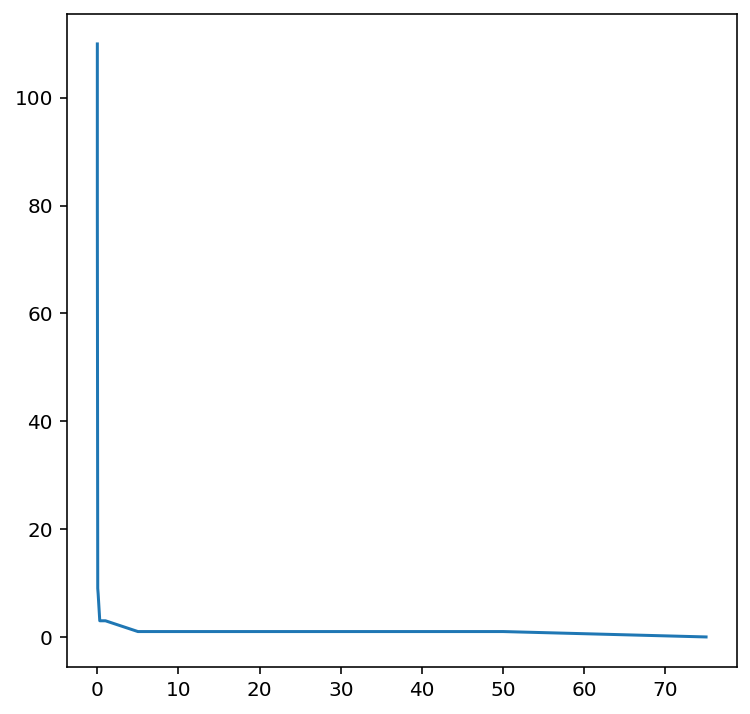

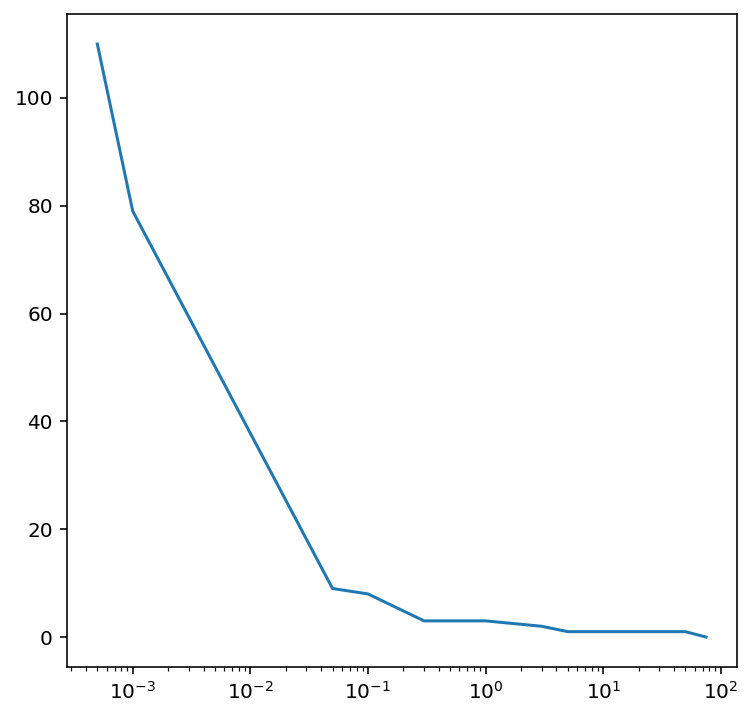

In [107]:
alphas = [0.0005, 0.001, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
l0_norms = []

for alpha in alphas:
    model_lasso = Lasso(alpha=alpha)
    model_lasso.fit(X_train, y)
    coefs = model_lasso.coef_
    l0_norm = 0
    for coef in coefs:
        if coef != 0:
            l0_norm += 1
    l0_norms.append(l0_norm)

plt.plot(alphas, l0_norms)
plt.show()
plt.plot(alphas, l0_norms)
plt.xscale('log')
plt.show()

In [114]:
model_lasso = Lasso(alpha=10)
model_lasso.fit(X_train, y)
output_lasso = model_lasso.predict(X_train)
model_ridge = Ridge(alpha=0.0005)
model_ridge.fit(X_train, y)
output_ridge = model_ridge.predict(X_train)

In [135]:
X_train['lasso'] = pd.Series(output_lasso, index=X_train.index)
X_train['ridge'] = pd.Series(output_ridge, index=X_train.index)

model_ridge = Ridge(alpha=0.0005)
model_ridge.fit(X_train, y)
print("Ensemble Ridge Score: " + str(model_ridge.score(X_train,y)))

Ensemble Ridge Score: 0.9473151078894951


C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [137]:
import sys
!{sys.executable} -m pip install xgboost

  Using cached https://files.pythonhosted.org/packages/cf/bf/affc47084baa8483deb674b2eb9b67416ff6754950ba2344297a2cd10e4a/xgboost-1.0.0-py3-none-win_amd64.whl


In [138]:
import xgboost as xgb

In [175]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [176]:
model_xgb = xgb.XGBRegressor(max_depth=2) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [177]:
xgb_preds = model_xgb.predict(X_train)

u = mean_squared_error(y,xgb_preds)
true_mean = [y.mean()] * y.shape[0]
v = mean_squared_error(y,true_mean)

score = 1 - (u/v)
print("XGB Score: " + str(score))

XGB Score: 0.9521292802011088
